In [1]:
# NA sample target 비율 확인
# target=1 오버 샘플링
# light gbm cv=5로 성능 빠르게 확인
# 피드백

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('dataset/train.csv', index_col=0)
test = pd.read_csv('dataset/test.csv', index_col=0)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
id,,,,,,,,,,,,,,,
0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0


In [4]:
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']

In [5]:
data.isnull().sum()  

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

In [6]:
from collections import Counter
# index 찾기
mis_var_features = ['workclass', 'occupation', 'native.country']
def findMissIndex(df, mis_var_feature):
    index = data[data[mis_var_feature].isnull()].index
    return index

mis_work_indices = findMissIndex(data, mis_var_features[0])
mis_occ_indices = findMissIndex(data, mis_var_features[1])
mis_con_indices = findMissIndex(data, mis_var_features[2])
print(len(mis_work_indices), len(mis_occ_indices), len(mis_con_indices))
len(set(mis_work_indices).intersection(set(mis_occ_indices)) )
len(set(mis_work_indices).intersection(set(mis_con_indices)) )

# 1. null sample에 대해 workclass와 occupation은 모두 겹침(제거!)
# 2. null sample에 대해 workclass와 native.country는 27개만 겹침
# 3. occupation index를 모두 제거하고 native.country는 따로 처리하자

1836 1843 583


27

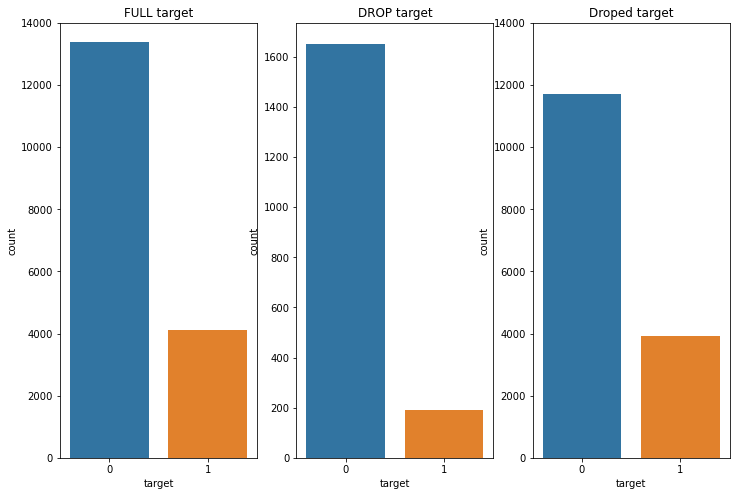

In [7]:
# 제거할 index들의 target 분포를 확인하자
f, ax = plt.subplots(1,3,figsize=(12,8))
sns.countplot(data['target'], ax=ax[0])
ax[0].set(title='FULL target')
ax[0].set_ylim(0, 14000)
sns.countplot(data.loc[mis_occ_indices]['target'], ax=ax[1])
ax[1].set(title='DROP target')

# 제거 후 target 분포
data.drop(mis_occ_indices, axis=0, inplace=True)


sns.countplot(data['target'], ax=ax[2])
ax[2].set_ylim(0, 14000)
ax[2].set(title='Droped target')

plt.show()

In [8]:
data['native.country'].fillna('United-States', inplace=True)
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
target            0
dtype: int64

# Label Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = [col for col in data.columns if data[col].dtype=='object']

for var in categorical_columns:
    le = LabelEncoder()
    le.fit(data[var])
    data[var] = le.transform(data[var])
    test[var] = le.transform(test[var])

# Capital

In [10]:
data['capital'] = (2*data['capital.gain']+data['capital.loss'])/3
test['capital'] = (2*test['capital.gain']+test['capital.loss'])/3

# Age

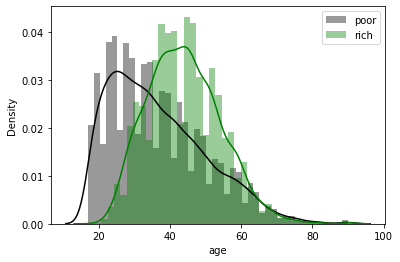

In [11]:
index = data[data['target']==0].index
sns.distplot(data.loc[index, 'age'], color='black',label='poor')
index = data[data['target']==1].index
sns.distplot(data.loc[index, 'age'], color='green', label='rich')
plt.legend()
plt.show()

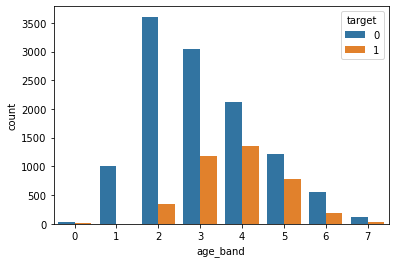

In [12]:
data['age_band']=0
for i in range(1,8):
    index = data[(10*i<data['age'])&(data['age']<=10*(i+1))].index
    data.loc[index, 'age_band']=i
    
test['age_band']=0
for i in range(1,8):
    index = test[(10*i<data['age'])&(test['age']<=10*(i+1))].index
    test.loc[index, 'age_band']=i

sns.countplot(x='age_band', hue='target', data=data)
plt.show()

# Martial

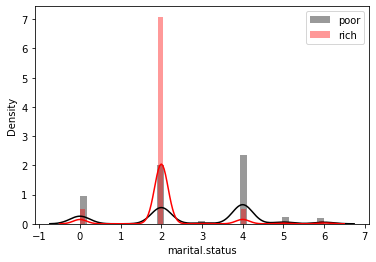

In [13]:
index = data[data['target']==0].index
sns.distplot(data.loc[index, 'marital.status'], color='black',label='poor')
index = data[data['target']==1].index
sns.distplot(data.loc[index, 'marital.status'], color='red', label='rich')
plt.legend()
plt.show()

In [14]:
data['martial']=0
index = data[data['marital.status']==0].index
data.loc[index, 'martial'] = 1

test['martial']=0
index = test[test['marital.status']==0].index
test.loc[index, 'martial'] = 1

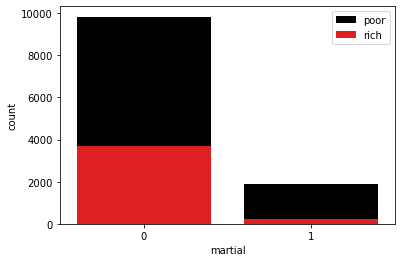

In [15]:
index = data[data['target']==0].index
sns.countplot(data.loc[index, 'martial'], color='black',label='poor')
index = data[data['target']==1].index
sns.countplot(data.loc[index, 'martial'], color='red', label='rich')
plt.legend()
plt.show()

# Edu

<AxesSubplot:xlabel='education.num', ylabel='count'>

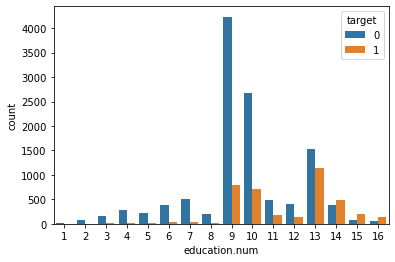

In [16]:
sns.countplot('education.num', hue='target', data=data)

<AxesSubplot:xlabel='edu', ylabel='count'>

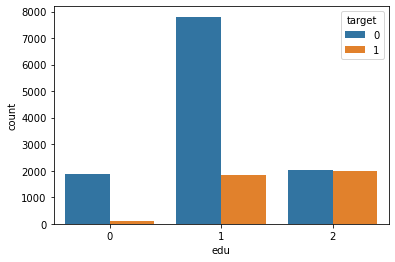

In [17]:
data['edu'] = 0
index = data[(data['education.num']>=9) & (data['education.num']<13)].index
data.loc[index, 'edu'] = 1
index = data[(data['education.num']>=13)].index
data.loc[index, 'edu'] = 2

test['edu'] = 0
index = test[(test['education.num']>=9) & (test['education.num']<13)].index
test.loc[index, 'edu'] = 1
index = test[(test['education.num']>=13)].index
test.loc[index, 'edu'] = 2


sns.countplot('edu', hue='target', data=data)

In [18]:
cols = ['sex', 'race', 'native.country']
data.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Original_data

In [19]:
categorical_columns.remove('sex')
categorical_columns.remove('race')
categorical_columns.remove('native.country')

In [20]:
categorical_columns

['workclass', 'education', 'marital.status', 'occupation', 'relationship']

In [21]:
one_hot = True
up_sample = False

In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score

# up sample
if up_sample:
    data = pd.concat([data, data[data['target']==1]], axis=0)
# one-hot
if one_hot:
    data = pd.get_dummies(columns=categorical_columns, data=data)
    test = pd.get_dummies(columns=categorical_columns, data=test)

# model
model = CatBoostClassifier(random_state=123)

label = 'target'
y_train = data[label]
X_train = data.drop(label, axis=1)

print(X_train.shape, y_train.shape)


kfold = KFold(n_splits=5, shuffle=True)

print(f'### 5 fold CV of CBM ###')
cv_result = cross_val_score(model, X_train, y_train, 
                            cv=kfold, scoring='accuracy', n_jobs=-1)
print(f'CV mean:{cv_result.mean()*100:.6f} +- std:{cv_result.std():.6f}\n')

(15637, 60) (15637,)
### 5 fold CV of CBM ###
CV mean:86.352834 +- std:0.007774



In [23]:
model.fit(X_train, y_train)
pred = model.predict(test)
sub = pd.read_csv('dataset/sample_submission.csv')
sub['target'] = pred
sub.to_csv('result/day3.csv', index=False)

# 결과분석

In [24]:
from xgboost import XGBRFClassifier, plot_importance
from xgboost import plot_importance as plot1
model1 = XGBRFClassifier(random_state=0)
model1.fit(X_train, y_train)


[17:59:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [25]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance as plot2
model2 = LGBMClassifier(random_state=0)
model2.fit(X_train, y_train)



LGBMClassifier(random_state=0)

In [26]:
from catboost import CatBoostClassifier

model3 = CatBoostClassifier(random_state=0)
model3.fit(X_train, y_train)



Learning rate set to 0.03333
0:	learn: 0.6616583	total: 4.91ms	remaining: 4.9s
1:	learn: 0.6293172	total: 9.61ms	remaining: 4.79s
2:	learn: 0.6035678	total: 14.5ms	remaining: 4.82s
3:	learn: 0.5810008	total: 19.4ms	remaining: 4.83s
4:	learn: 0.5582541	total: 24.1ms	remaining: 4.8s
5:	learn: 0.5390875	total: 28.8ms	remaining: 4.78s
6:	learn: 0.5202165	total: 33.4ms	remaining: 4.74s
7:	learn: 0.5031803	total: 37.8ms	remaining: 4.68s
8:	learn: 0.4893442	total: 42.2ms	remaining: 4.65s
9:	learn: 0.4757401	total: 47ms	remaining: 4.65s
10:	learn: 0.4669847	total: 51.4ms	remaining: 4.63s
11:	learn: 0.4564595	total: 55.8ms	remaining: 4.59s
12:	learn: 0.4460675	total: 60.3ms	remaining: 4.58s
13:	learn: 0.4367639	total: 64.7ms	remaining: 4.56s
14:	learn: 0.4277720	total: 69.1ms	remaining: 4.54s
15:	learn: 0.4194746	total: 73.7ms	remaining: 4.53s
16:	learn: 0.4125451	total: 78.2ms	remaining: 4.52s
17:	learn: 0.4059391	total: 82.5ms	remaining: 4.5s
18:	learn: 0.4001762	total: 87.1ms	remaining: 4.5s

In [27]:
X_train

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,capital,age_band,martial,edu,...,occupation_10,occupation_11,occupation_12,occupation_13,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5
id,,,,,,,,,,,,,,,,,,,,,
0,32,309513,12,0,0,40,0.0,3,0,1,...,0,0,0,0,1,0,0,0,0,0
1,33,205469,10,0,0,40,0.0,3,0,1,...,0,0,0,0,1,0,0,0,0,0
2,46,149949,10,0,0,40,0.0,4,0,1,...,0,0,0,0,1,0,0,0,0,0
3,23,193090,13,0,0,30,0.0,2,0,2,...,0,0,0,0,0,0,0,1,0,0
4,55,60193,9,0,0,40,0.0,5,1,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17465,45,199590,3,0,0,40,0.0,4,0,0,...,0,0,0,0,1,0,0,0,0,0
17467,44,71556,14,0,0,50,0.0,4,0,2,...,0,1,0,0,1,0,0,0,0,0
17468,58,181974,16,0,0,99,0.0,5,0,2,...,0,0,0,0,0,1,0,0,0,0


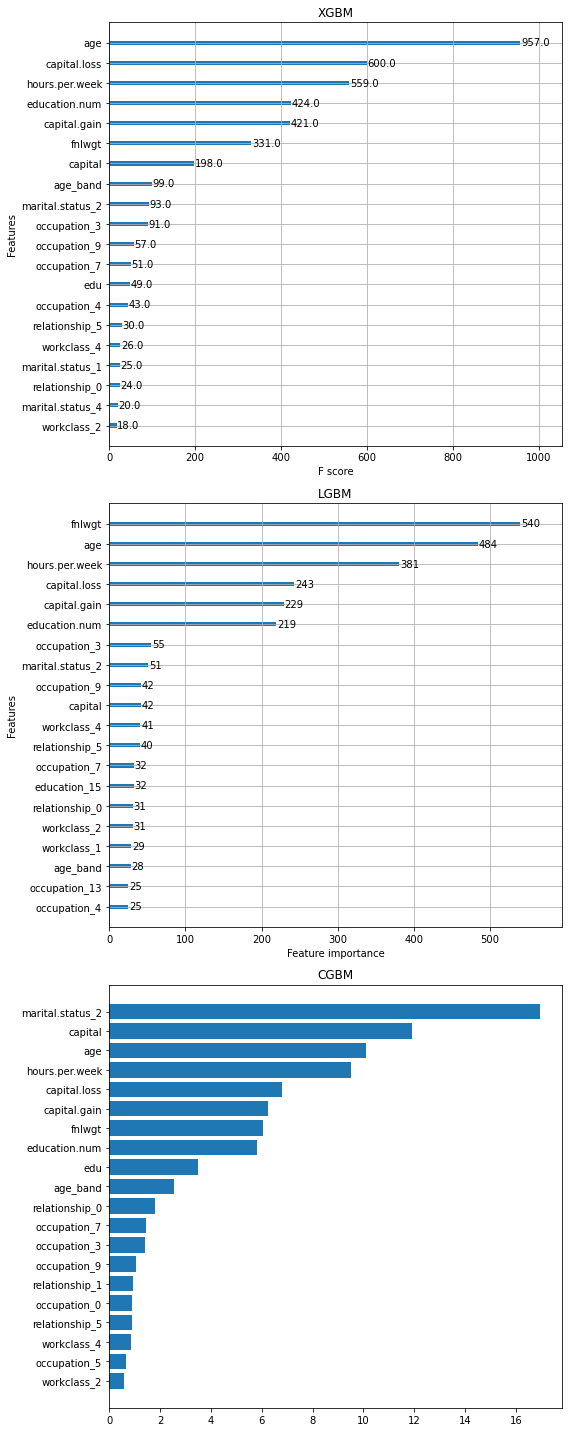

In [39]:
feature_importance1 = model1.feature_importances_
feature_importance2 = model2.feature_importances_
feature_importance3 = model3.feature_importances_

sorted_idx1 = np.argsort(feature_importance1)
sorted_idx2 = np.argsort(feature_importance2)
sorted_idx3 = np.argsort(feature_importance3)

f, ax = plt.subplots(3,1,figsize=(8,20))
plot1(model1, max_num_features=20, title='XGBM', ax=ax[0])
plot2(model2, max_num_features=20, title='LGBM', ax=ax[1])
ax[2].barh(range(len(sorted_idx3))[-20:], feature_importance3[sorted_idx3][-20:], align='center')
plt.yticks(range(len(sorted_idx3))[-20:], np.array(X_train.columns)[sorted_idx3][-20:])
plt.title('CGBM')
plt.tight_layout()
plt.show()


In [29]:
xg = X_train.columns[sorted_idx1][-3:]
lg = X_train.columns[sorted_idx2][-3:]
cat = X_train.columns[sorted_idx3][-3:]

In [30]:
xg

Index(['edu', 'relationship_0', 'marital.status_2'], dtype='object')

In [31]:
lg

Index(['hours.per.week', 'age', 'fnlwgt'], dtype='object')

In [32]:
model3